In [3]:
# from sklearnex import patch_sklearn 
# patch_sklearn()
import pandas as pd
import numpy as np
import pennylane as qml
import tensorflow as tf
import matplotlib.pyplot as plt
import time 

from sklearn.svm import SVC # your usual code without any changes
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import datetime

In [4]:
# Dimension of the bipartite system
folder = 'efficiency_study'

# Number of Principal components to reduce the dataset's dimensionality
n_pca=32

# pennylane works with doubles and tensorflow works with floats.
# We ask tensorflow to work with doubles
tf.keras.backend.set_floatx('float64')

# Initialize a seed for np, so that our results are reproducible
np.random.seed(42)

In [5]:
# Amplitude encoding of 64 variables using 5 qubits (can encode up to 32 inputs)
# Number of qubits of the system
nqubits = 5
# We define a device
dev = qml.device("default.qubit", wires = nqubits)

# We define de circuit of our kernel. We use AmplitudeEmbedding which returns an
# operation equivalent to amplitude encoding of the first argument
@qml.qnode(dev)
def kernel_circ(a,b):
    qml.AmplitudeEmbedding(a, wires=range(nqubits), pad_with=0, normalize=True)
    # Computes the adjoint (or inverse) of the amplitude encoding of b
    qml.adjoint(qml.AmplitudeEmbedding(b, wires=range(nqubits), pad_with=0, normalize=True))    # We return an array with the probabilities fo measuring each possible state in the
    # computational basis
    return qml.probs(wires=range(nqubits))

In [6]:
def qkernel(A, B):
  return np.array([[kernel_circ(a,b)[0] for b in B] for a in A])

In [15]:
sizes=np.arange(100, 1001, 100)
pca_times=[]
training_times=[]
prediction_times=[]
total_times=[]
accuracy_n=[]

In [24]:
for size in sizes:
    start=time.time()

    x_train = np.genfromtxt('./dataset/'+folder+'/train/x_n_'+str(size)+'.csv', delimiter=",",dtype=None)
    x_test = np.genfromtxt('./dataset/'+folder+'/test/x_test.csv', delimiter=",",dtype=None)

    start_pca = time.time()

    pca = PCA(n_components = n_pca)
    xs_train = pca.fit_transform(x_train)
    xs_test = pca.transform(x_test)

    end_pca=time.time()
    pca_times.append(end_pca - start_pca)


    y_train = np.genfromtxt('./dataset/'+folder+'/train/y_n_'+str(size)+'.csv', delimiter=",",dtype=None)
    y_test = np.genfromtxt('./dataset/'+folder+'/test/y_test.csv', delimiter=",",dtype=None)

    start_train=time.time()
    svm = SVC(kernel = qkernel).fit(xs_train, y_train)
    end_train=time.time()
    training_times.append(end_train - start_train)

    start_test=time.time()
    y_test_pred=svm.predict(xs_test)
    end_test=time.time()
    prediction_times.append(end_test-start_test)

    test_acc = accuracy_score(y_test_pred, y_test)
    end=time.time()
    total_times.append(end - start)

    accuracy_n.append(test_acc)
    # print("Test accuracy for n = {} : {}".format(size, test_acc))


In [ ]:
# Create a dictionary to save times
d={'size':sizes,'total_time': total_times,'pca_time': pca_times, 'training_time': training_times,
   'prediction_time': prediction_times, 'accuracy': accuracy_n,}

# Create a pandas dataframe from the dictionary
df = pd.DataFrame(data=d)

# Save the dataframe to a CSV file
df.to_csv('./results/efficiency_results.csv', index=False)

In [29]:
results=pd.read_csv("./results/efficiency_results.csv")
print(results)
ex_time=np.sum(results['total_time'])
print(ex_time)
print(str(datetime.timedelta(seconds=ex_time)))

   size    total_time  pca_time  training_time  prediction_time  accuracy
0   100    929.266728  0.600583     232.357716       696.166130  0.683333
1   200   2389.382585  0.003664     920.592516      1468.668005  0.620000
2   300   4897.760765  0.005475    2437.305936      2460.231932  0.640000
3   400   7287.650731  0.003538    4203.814108      3083.713228  0.756667
4   500  10770.610564  0.003259    6773.568293      3996.627862  0.783333
5   600  14489.122067  0.005973    9665.883191      4822.864136  0.773333
6   700  18640.010507  0.004629   13122.012113      5517.763067  0.776667
7   800  22141.673168  0.004902   16084.014137      6057.279932  0.773333
8   900  28693.900316  0.005013   21385.270577      7308.255956  0.770000
9  1000  36496.319263  0.006986   27951.266791      8544.848698  0.780000
146735.696693182
1 day, 16:45:35.696693


In [34]:
# sizes=np.array([100,200,300,400])
# total_times=[1203.5146133899689, 2987.0052218437195, 5389.7877678871155, 8381.283021688461]
# pca_times=[0.6374199390411377, 0.0027985572814941406, 0.0031075477600097656, 0.0032532215118408203]
# training_times= [300.7612683773041, 1190.8078904151917, 2694.8653140068054, 4785.023932695389]
# prediction_times= [901.9093019962311, 1796.0588626861572, 2694.776803255081, 3596.131491661072]


-1620.3897402565508 + 22.93105715041957 x^1 + -0.009586670353987144 x^2 + 2.4372714258277808e-05 x^3
R-squared:  0.9982760608540151
470.78914112638995 + 4.383421604198709 x^1 + 0.03062830817112343 x^2
R-squared:  0.9968076032722634


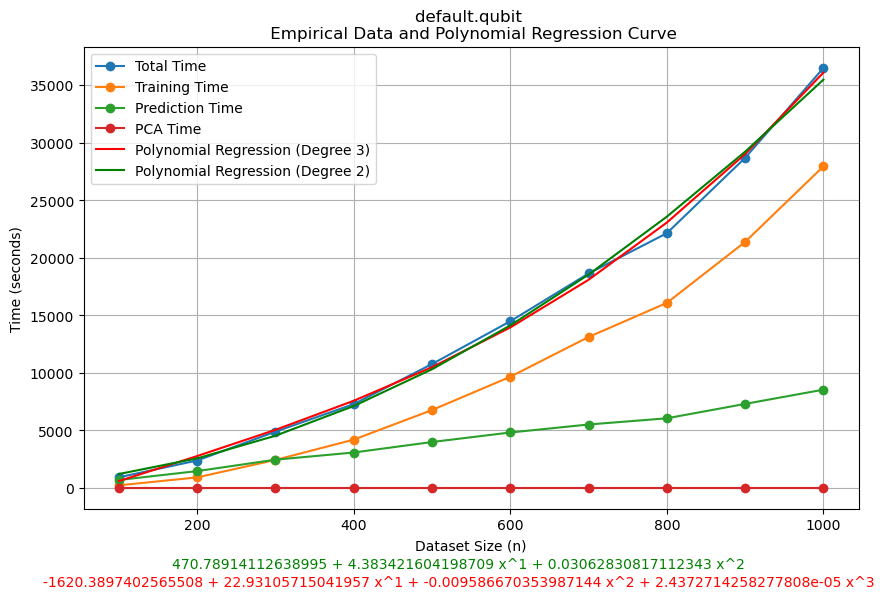

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Plotting
plt.figure(figsize=(10, 6))

# Plot total times
plt.plot(results['size'], results['total_time'], label='Total Time', marker='o')
plt.plot(results['size'], results['training_time'], label='Training Time', marker='o')
plt.plot(results['size'], results['prediction_time'], label='Prediction Time', marker='o')
plt.plot(results['size'], results['pca_time'], label='PCA Time', marker='o')

# Polynomial regression degree
degree = 3

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_3 = LinearRegression()
model_3.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_3 = model_3.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_3, color='red', label='Polynomial Regression (Degree {})'.format(degree))

# Polynomial regression degree
degree = 2

# Transform input data to polynomial features
poly_features = PolynomialFeatures(degree=degree)
sizes=np.array(results['size'])
X_poly = poly_features.fit_transform(sizes.reshape(-1, 1))

# Fit polynomial regression model
model_2 = LinearRegression()
model_2.fit(X_poly, results['total_time'])

# Predict execution times for input sizes
y_pred_2 = model_2.predict(X_poly)

# Plot fitted curve
plt.plot(results['size'], y_pred_2, color='green', label='Polynomial Regression (Degree {})'.format(degree))


#display regression coefficients and R-squared value of model degree 3
i=1
poly_3=str(model_3.intercept_)
for c in model_3.coef_[1:]:
    poly_3 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_3)
print('R-squared: ', r2_score(results['total_time'], y_pred_3))


#display regression coefficients and R-squared value of model degree 2
i=1
poly_2=str(model_2.intercept_)
for c in model_2.coef_[1:]:
    poly_2 += ' + '+str(c)+' x^'+str(i)
    i+=1
print(poly_2)
print('R-squared: ', r2_score(results['total_time'], y_pred_2))

plt.figtext(0.5, 0.03, poly_2, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='green') 
plt.figtext(0.5, 0, poly_3, fontsize = 10, wrap=True,
            horizontalalignment='center', verticalalignment='top',
            color='red') 

plt.xlabel('Dataset Size (n)')
plt.ylabel('Time (seconds)')
plt.title('default.qubit \n Empirical Data and Polynomial Regression Curve')
plt.legend()
plt.grid(True)
plt.show()

In [56]:

f_2 = lambda n: model_2.intercept_ + model_2.coef_[1]*n + model_2.coef_[2]*(n**2)
#print(f_2(2000))
t_2=str(datetime.timedelta(seconds=f_2(2000)))


f_3 = lambda n : model_3.intercept_ + model_3.coef_[1]*n + model_3.coef_[2]*(n**2) + model_3.coef_[3]*(n**3)
#print(f_3(2000))
t_3=str(datetime.timedelta(seconds=f_3(2000)))

print('Estimation for \n * n=2000 (full training dataset size) \n * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)')
print('[ ' + t_2 + ' , ' + t_3 + ' ]')

Estimation for 
 * n=2000 (full training dataset size) 
 * Test set of 300 samples (100 SEP, 1OO ENT-PPT, 100 ENT-NPPT)
[ 1 day, 12:35:50.865034 , 2 days, 7:47:56.757211 ]


In [4]:
specs=['default.qubit', 'sklearnex patch', 'lightning.qubit', '4 core MP', '8 core MP', '16 core MP']
total_times=[929.0303208827972, 469.2156777381897, 465.96590399742126, 473.1370894908905, 441.6203305721283, 470.88121700286865]
pca_times=[ 0.0045320987701416016, 1.7428326606750488, 1.5053131580352783, 1.505403757095337, 1.5070369243621826, 2.4730515480041504]
training_times= [232.80273127555847, 115.66362380981445, 114.7699122428894, 117.40771007537842, 110.54020190238953, 117.55744004249573]
prediction_times= [ 696.1845543384552, 351.40579557418823, 349.2262830734253, 353.7597680091858, 329.11009454727173, 350.5866916179657]

In [9]:
# Create a dictionary to save times
d={'spec':specs,'total_time': total_times,'pca_time': pca_times, 'training_time': training_times,
   'prediction_time': prediction_times}

# Create a pandas dataframe from the dictionary
df = pd.DataFrame(data=d)

# order by total_time
df=df.sort_values(by=['total_time'], axis=0, ascending=True)

print(df)

# Save the dataframe to a CSV file
df.to_csv('./results/specs_comparison.csv', index=False)

              spec  total_time  pca_time  training_time  prediction_time
4        8 core MP  441.620331  1.507037     110.540202       329.110095
2  lightning.qubit  465.965904  1.505313     114.769912       349.226283
1  sklearnex patch  469.215678  1.742833     115.663624       351.405796
5       16 core MP  470.881217  2.473052     117.557440       350.586692
3        4 core MP  473.137089  1.505404     117.407710       353.759768
0    default.qubit  929.030321  0.004532     232.802731       696.184554
